In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
import math
import planetengine
from planetengine import InitialConditions
from planetengine import Analysis

In [33]:
radii = (1.2, 2.2) #(1.2, 2.2)
radRes = 64
angPi = 1. / 3.
offsetPi = 1. / 3.

mesh = uw.mesh._FeMesh_Annulus(
    elementRes = (radRes, (4*int(angPi*math.pi*(int(radRes*radii[1]/(radii[1] - radii[0])))/4.))),
    radialLengths = (radii[0], radii[1]),
    angularExtent = (offsetPi * 180., (angPi + offsetPi) * 180.)
    )


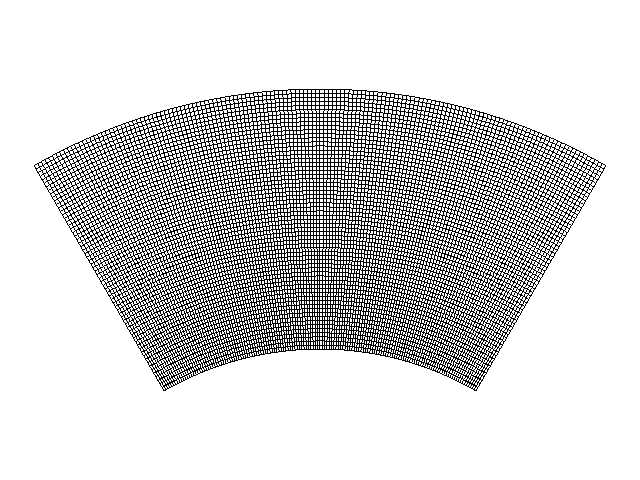

In [34]:
figMesh = glucifer.Figure(edgecolour = "")
figMesh.append(glucifer.objects.Mesh(mesh, nodeNumbers = False))
figMesh.show()

In [35]:
temperatureField = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 1)
temperatureDotField = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 1)
pressureField = uw.mesh.MeshVariable(mesh = mesh.subMesh, nodeDofCount = 1)
velocityField = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 2)

In [43]:
temperatureField.data[:] = 0.
print temperatureField.data
temperatureField.load("testing_temperatureField.h5_00000010", interpolate = True)

[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]
As the fields mesh geometry is an Annulus only the internal nodes will have their values
interpolated from the hdf5 file. The use is required to manually initialise the field values
on the boundary nodes. ie
  field.data[mesh.specialSets["boundaryNodes"].data] = 1.23


In [5]:
swarm = uw.swarm.Swarm(mesh, particleEscape = True)
layout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm, particlesPerCell = 10)
swarm.populate_using_layout(layout)
advector = uw.systems.SwarmAdvector(
    swarm = swarm,
    velocityField = velocityField,
    order = 2,
    )
repopulator = uw.swarm.PopulationControl(
    swarm,
    aggressive = True,
    splitThreshold = 0.15,
    maxDeletions = 2,
    maxSplits = 10,
    particlesPerCell = 10
    )

In [6]:
materialVar = swarm.add_variable(dataType = "int", count = 1)

In [7]:
materials = [
    {
    'name': 'mantle',
    'buoyancy': 1.,
    },
    {
    'name': 'continent',
    'buoyancy': 1.1,
    },
    {
    'name': 'basal',
    'buoyancy': 0.9,
    }
    ]

In [8]:
curvedBox = planetengine.CoordSystems.Radial(
    mesh.radialLengths,
    mesh.angularExtent,
    boxDims = ((0., angPi * 6.), (0., 1.))
    ).curved_box

In [9]:
initialConditions = InitialConditions.Group([
    InitialConditions.Sinusoidal(temperatureField.data, curvedBox(mesh.data)),
    InitialConditions.Indices(
        temperatureField.data[:],
        [(mesh.specialSets["outer"].data, 0.),
        (mesh.specialSets["inner"].data, 1.)]
        ),
    InitialConditions.Extents(
        materialVar.data, 
        curvedBox(swarm.particleCoordinates.data),
        initialExtents = [
            (0, fn.misc.constant(True)),
            (1, fn.shape.Polygon(np.array([[0.5, 0.965], [0.5, 1.], [1.5, 1.], [1.5, 0.965]]))),
            (2, fn.shape.Polygon(np.array([[0., 0.], [0., 0.02], [2., 0.02], [2., 0.]]))),
            ]
        ),
    InitialConditions.SetVal([velocityField.data, pressureField.data, temperatureDotField.data], 0.),
    ])

In [10]:
initialConditions.apply_condition()


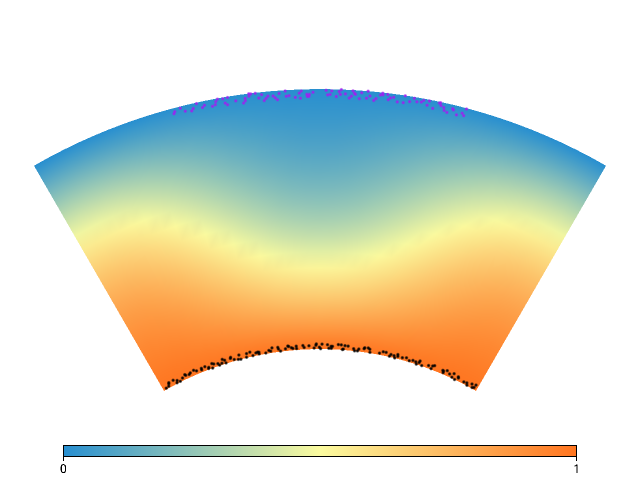

In [11]:
fig = glucifer.Figure(edgecolour = "", quality = 2)
figTempComponent = fig.Surface(mesh, temperatureField, colourBar = True)
figVelComponent = fig.VectorArrows(mesh, velocityField)
figMaterialComponent = fig.Points(
    swarm, fn_colour = materialVar, fn_mask = materialVar, fn_size = 4.,
    colours = "purple", colourBar = False
    )
#figYieldComponent = fig.Points(
    #visSwarm, fn_mask = plasticViscFn < creepViscFn, fn_colour = 1., fn_size = 4.,
    #colours = "pink", opacity = 1. , colourBar = False
    #)
#figViscComponent = fig.Contours(
    #mesh, fn.math.log10(viscosityFn),
    #colours = "red black", interval = 0.5, colourBar = False 
    #)
fig.show()

In [12]:
inner = mesh.specialSets["inner"]
outer = mesh.specialSets["outer"]

velBC = uw.conditions.RotatedDirichletCondition(
    variable = velocityField,
    indexSetsPerDof= (inner + outer, None),
    basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
    )

tempBC = uw.conditions.DirichletCondition(
    variable = temperatureField,
    indexSetsPerDof = (inner + outer,)
    )

In [13]:
maxVisc = 3e4
Ra = 1e5
tau0 = 1e5
tau1 = 1e7

z_hat = mesh.fn_unitvec_radial()
invDensityFn = temperatureField * Ra * fn.branching.map(
    fn_key = materialVar,
    mapping = {matIndex: params['buoyancy'] for matIndex, params in enumerate(materials)}
    )
magnitude = fn.math.sqrt(fn.coord()[0]**2 + fn.coord()[1]**2)
depthFn = (mesh.radialLengths[1] - magnitude)
yieldStressFn = tau0 + (tau1 * depthFn)
secInvFn = fn.tensor.second_invariant(fn.tensor.symmetric(velocityField.fn_gradient))
plasticViscFn = yieldStressFn / (2. * secInvFn + 1e-18)
creepViscFn = fn.math.pow(fn.misc.constant(maxVisc), -1. * (temperatureField - 1.))
viscosityFn = fn.misc.min(maxVisc, fn.misc.max(1., fn.misc.min(creepViscFn, plasticViscFn)))
#viscosityFn = 1.
#viscosityFn = fn.branching.map(
    #fn_key = materialVar,
    #mapping = {0: rawViscosityFn, 1: rawViscosityFn * 1.1}
    #)

In [14]:
stokes = uw.systems.Stokes(
    velocityField = velocityField,
    pressureField = pressureField,
    conditions = [velBC,],
    fn_viscosity = viscosityFn,
    fn_bodyforce = invDensityFn * z_hat,
    _removeBCs = False,
    )

solver = uw.systems.Solver(stokes)

advDiff = uw.systems.AdvectionDiffusion(
    phiField = temperatureField,
    phiDotField = temperatureDotField,
    velocityField = velocityField,
    fn_diffusivity = fn.misc.constant(1.),
    conditions = [tempBC,]
    )

In [15]:
solver.solve(nonLinearIterate = True)

In [16]:
fig = glucifer.Figure(edgecolour = "", quality = 2)
figTempComponent = fig.Surface(mesh, temperatureField, colourBar = True)
figVelComponent = fig.VectorArrows(mesh, velocityField)
figMaterialComponent = fig.Points(
    swarm, fn_mask = materialVar, fn_colour = 1., fn_size = 4.,
    colours = "turquoise", colourBar = False
    )
#figYieldComponent = fig.Points(
    #visSwarm, fn_mask = plasticViscFn < creepViscFn, fn_colour = 1., fn_size = 4.,
    #colours = "pink", opacity = 1. , colourBar = False
    #)
figViscComponent = fig.Contours(
    mesh, fn.math.log10(viscosityFn),
    colours = "red black", interval = 0.5, colourBar = False 
    )

In [17]:
def postSolve():
    # realign solution using the rotation matrix on stokes
    uw.libUnderworld.Underworld.AXequalsX(
        stokesSLE._rot._cself,
        stokesSLE._velocitySol._cself,
        False
        )
    # remove null space - the solid body rotation velocity contribution
    uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(
        stokesSLE._velocitySol._cself, 
        stokesSLE._vnsVec._cself
        )

In [18]:
def update():
    solver.solve(nonLinearIterate = False, callback_post_solve = postSolve)
    dt = min(advDiff.get_max_dt(), advector.get_max_dt)
    advDiff.integrate(dt)
    advector.integrate(dt)
    repopulator.repopulate()
    return dt

In [19]:
formatDict = {
    'Nu': "{:.1f}",
    'avTemp': "{:.2f}",
    'VRMS': "{:.2f}",
    'surfVRMS': "{:.2f}",
    'avVisc': "{:.1E}",
    'yielding': "{0:.0%}",
    'modeltime': "{:.1E}",
    'step': "{:.0f}",
    }

In [20]:
#meshHandle = mesh.save("mesh.h5")

In [21]:
step, modeltime = fn.misc.constant(0), fn.misc.constant(0.)

In [22]:
analyser = Analysis.Analyser('zerodData', {
    'Nu': Analysis.Analyse.DimensionlessGradient(temperatureField, mesh,
        surfIndexSet = mesh.specialSets["outer"], baseIndexSet = mesh.specialSets["inner"]
        ),
    'avTemp': Analysis.Analyse.ScalarFieldAverage(temperatureField, mesh),
    'VRMS': Analysis.Analyse.VectorFieldVolRMS(velocityField, mesh),
    'surfVRMS': Analysis.Analyse.VectorFieldSurfRMS(
        velocityField, mesh, outer
        ),
    'avVisc': Analysis.Analyse.ScalarFieldAverage(viscosityFn, mesh),
    'yielding': Analysis.Analyse.ScalarFieldAverage(
        fn.branching.conditional([(creepViscFn < plasticViscFn, 0.), (True, 1.)]),
        mesh
        ),
    'step': Analysis.Analyse.ArrayStripper(step, (0, 0)),
    'modeltime': Analysis.Analyse.ArrayStripper(modeltime, (0, 0)),
    })

In [23]:
dataCollector = Analysis.DataCollector([analyser])

In [24]:
checkpointer = planetengine.Checkpointer(
    outputPath = "testing_", #"Output\\",
    figs = [("fig.png", fig)],
    varsOfState = [
        (((temperatureField, "temperatureField.h5"),), (mesh, "mesh.h5")),
        (((materialVar, "materialVar.h5"),), (swarm, "swarm.h5")),
        ],
    dataCollector = dataCollector,
    step = step
    )

In [25]:
reporter = Analysis.Report(analyser.dataDict, formatDict, fig)

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '0.0E+00'), ('Nu', '1.7'), ('step', '0'), ('surfVRMS', '0.03'), ('VRMS', '1.27'), ('yielding', '0%')]



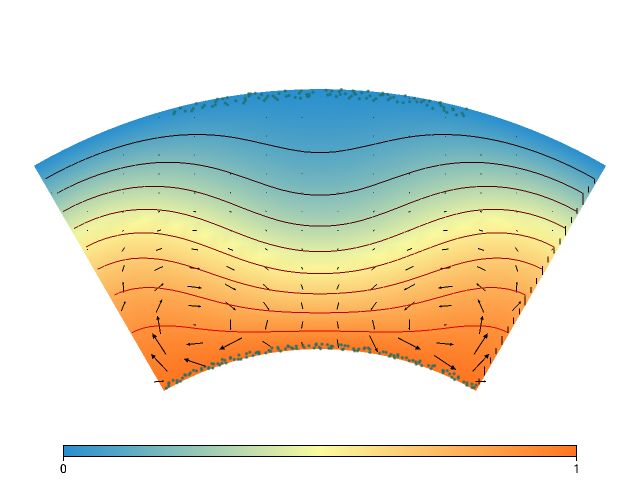

Checkpointing...
Checkpointed!


In [26]:
analyser.update()
dataCollector.update()
reporter.report()
checkpointer.checkpoint()

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '6.1E-04'), ('Nu', '1.7'), ('step', '1'), ('surfVRMS', '0.03'), ('VRMS', '1.27'), ('yielding', '0%')]



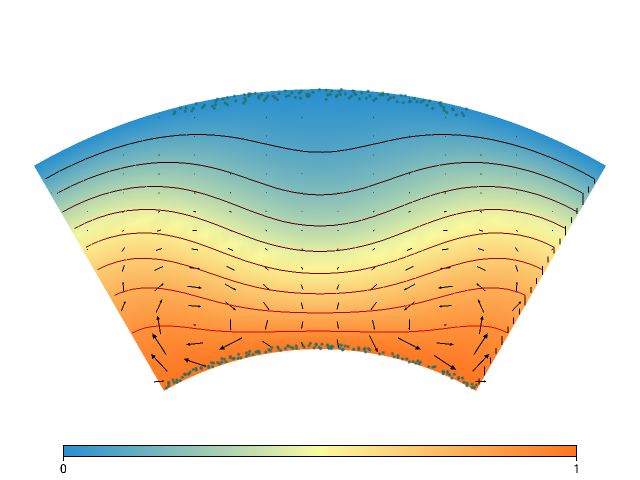

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '1.2E-03'), ('Nu', '1.7'), ('step', '2'), ('surfVRMS', '0.03'), ('VRMS', '1.27'), ('yielding', '0%')]



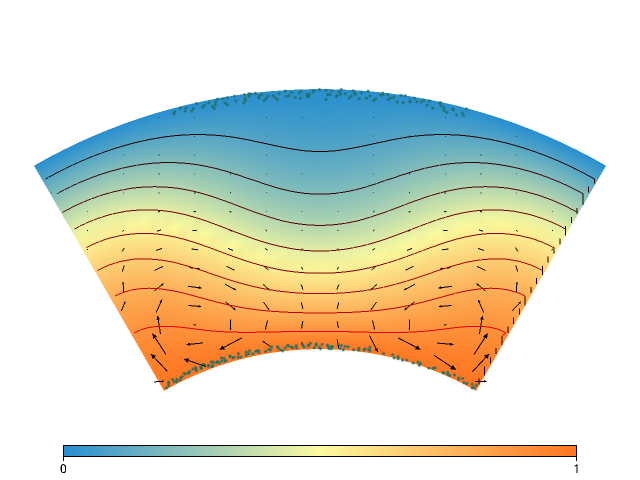

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '1.8E-03'), ('Nu', '1.7'), ('step', '3'), ('surfVRMS', '0.03'), ('VRMS', '1.26'), ('yielding', '0%')]



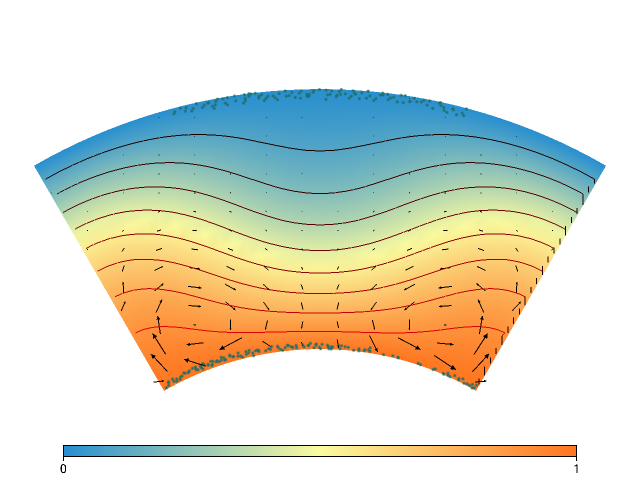

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '2.4E-03'), ('Nu', '1.7'), ('step', '4'), ('surfVRMS', '0.03'), ('VRMS', '1.25'), ('yielding', '0%')]



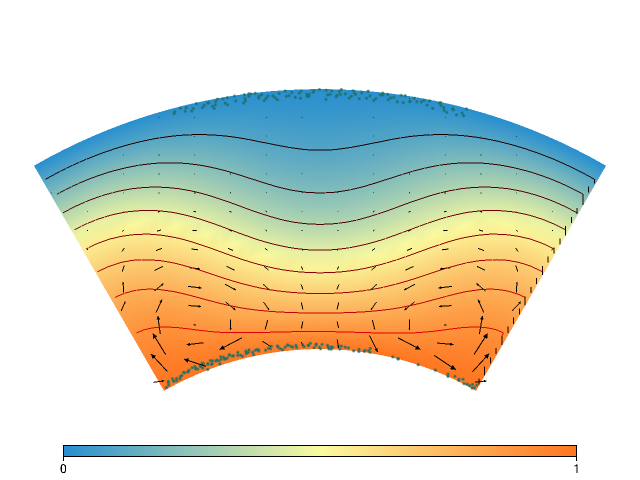

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '3.0E-03'), ('Nu', '1.7'), ('step', '5'), ('surfVRMS', '0.03'), ('VRMS', '1.24'), ('yielding', '0%')]



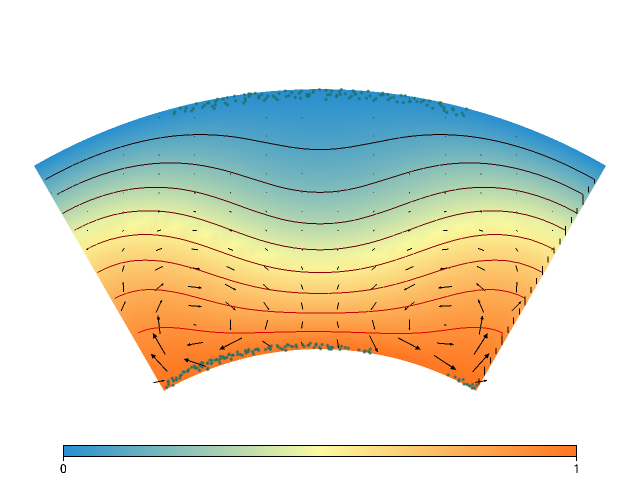

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '3.7E-03'), ('Nu', '1.7'), ('step', '6'), ('surfVRMS', '0.03'), ('VRMS', '1.23'), ('yielding', '0%')]



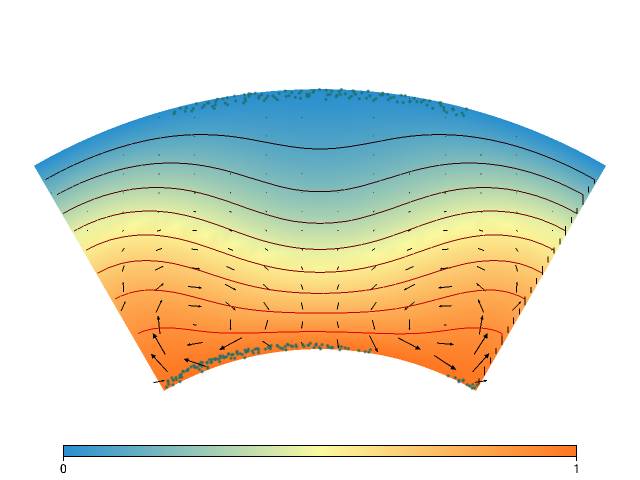

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '4.3E-03'), ('Nu', '1.7'), ('step', '7'), ('surfVRMS', '0.03'), ('VRMS', '1.21'), ('yielding', '0%')]



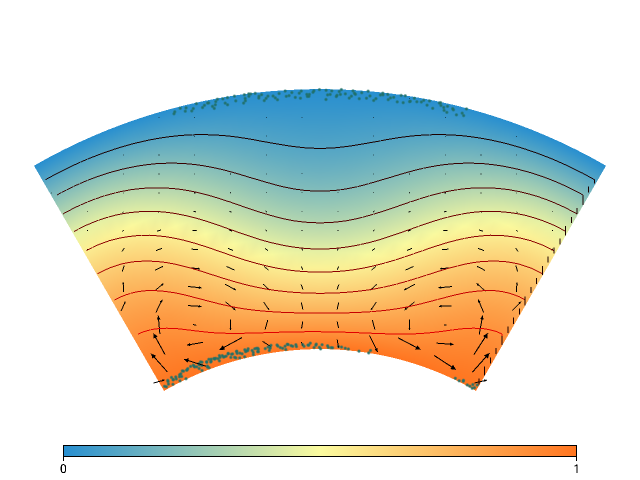

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '4.9E-03'), ('Nu', '1.7'), ('step', '8'), ('surfVRMS', '0.03'), ('VRMS', '1.20'), ('yielding', '0%')]



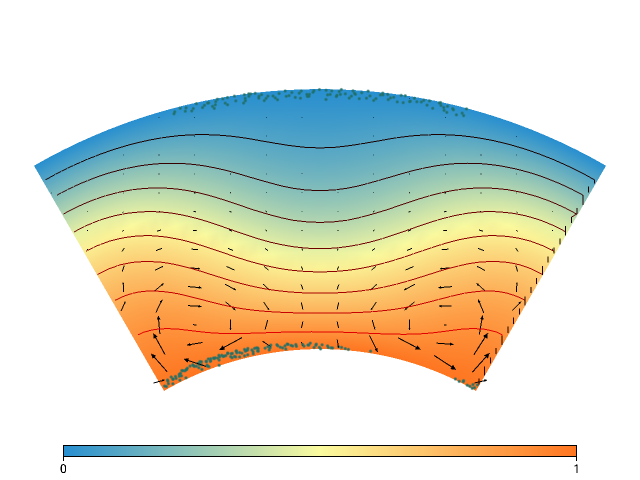

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '5.5E-03'), ('Nu', '1.7'), ('step', '9'), ('surfVRMS', '0.03'), ('VRMS', '1.19'), ('yielding', '0%')]



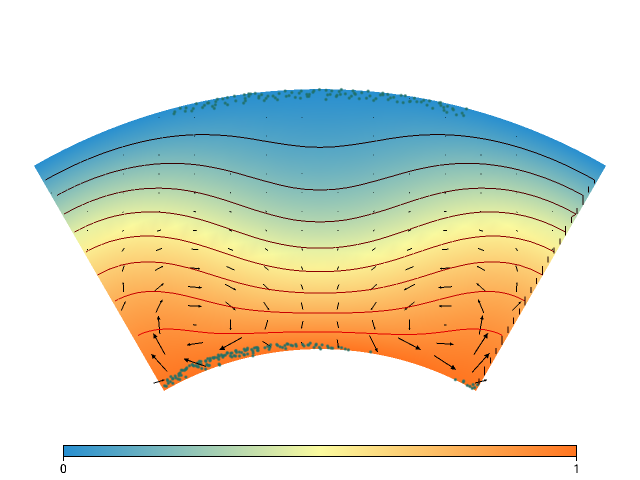

[('avTemp', '0.45'), ('avVisc', '4.1E+03'), ('modeltime', '6.1E-03'), ('Nu', '1.7'), ('step', '10'), ('surfVRMS', '0.03'), ('VRMS', '1.18'), ('yielding', '0%')]



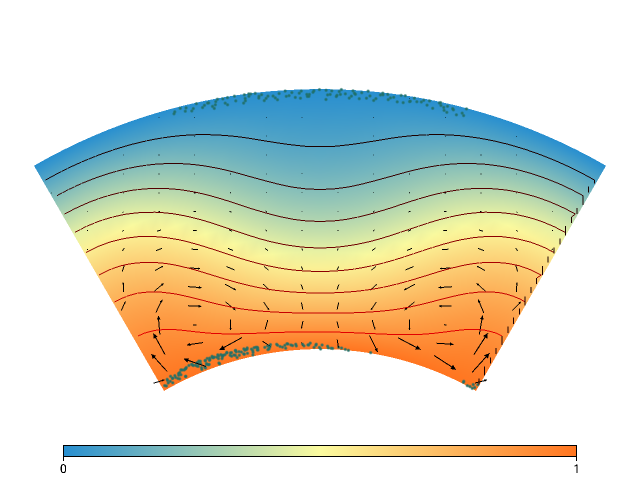

Checkpointing...
Checkpointed!


In [27]:
while step.value < 10:
    step.value += 1
    modeltime.value += update()
    if step.value % 1 == 0:
        analyser.update()
        dataCollector.update()
        reporter.report()
    if step.value % 10 == 0:
        checkpointer.checkpoint()

In [28]:
testobj = np.loadtxt('testingzerodData.csv', delimiter = ",")